In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [2]:
X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, n_clusters_per_class=5, random_state=12, n_informative=5, n_redundant=5, class_sep=3)

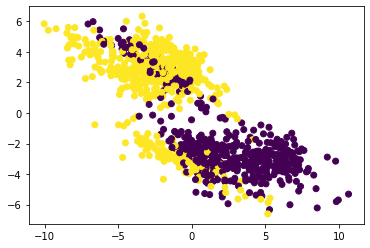

In [3]:
plt.scatter(X[:,2], X[:, -1], c=y)

In [4]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def grad(beta_, x, y):
   return x*(sigmoid(x.T@beta_)-y)/len(y)

def lasso_cost(X, beta, y, lam):
  z = X@beta
  return np.mean(-y*sigmoid(z)-(1-y)*np.log(1-sigmoid(z)))+np.sum(np.abs(beta))*lam



def l2(vec):
  return np.sqrt(np.sum(vec**2))

def prox_l1(x, lam):
  return np.piecewise(x, [x >lam, x <= lam, x<-lam], [lambda x:x-lam, 0, lambda x:x+lam])



In [5]:
class LassoLogisticRegression:

    def __init__(self, step_size='adaptive', lam=0.1, k=0.1, eta=0.1):
        self.step_size = step_size
        self.lam = lam
        self.k = k 
        self.eta = eta
        self.beta = None

    def fit(self, X, y, tol=10**-5, max_iter=1000):        
        error = []
        beta = [np.zeros(X.shape[1])]
        for _ in range(max_iter):        
            y_hat = sigmoid(X@beta[-1])
            if self.step_size == 'adaptive':
                self.step_size = self.line_search(beta[-1], X, y)
            beta.append(prox_l1(beta[-1]-self.step_size * np.dot(X.T,  y_hat - y) / len(X), self.step_size*self.lam ))         
            error.append(l2(y_hat-y)/len(X))
            if error[-1]<tol:
              break   
        self.beta = beta
        self.error = error

    def line_search(self, beta, X, y):
        alpha = [1]
        grad = X.T@(sigmoid(X@beta)-y)/len(y)
        search_vec = -grad
        t = -self.k*search_vec.T@grad
        while lasso_cost(X, beta, y, self.lam*alpha[-1])-lasso_cost(X, (beta+alpha[-1]*search_vec), y, self.lam*alpha[-1])<alpha[-1]*t:
            alpha.append(self.eta*alpha[-1])
        return alpha[-1]

    def predict(self, X):        
        return [1 if i > 0.5 else 0 for i in sigmoid(X@self.beta[-1])]


In [10]:
LLR = LassoLogisticRegression(step_size=0.1)
LLR.fit(X, y, max_iter=100)

0.81


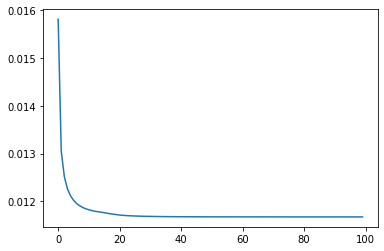

In [11]:
plt.plot(LLR.error)
print(accuracy_score(y, LLR.predict(X)))

In [9]:
from time import time

def group_lasso_cost(X, beta, y, penalty):
  z = X@beta
  return np.mean(-y*sigmoid(z)-(1-y)*np.log(1-sigmoid(z)))+penalty

def prox_l2_(beta_j, lam):
  return np.maximum(1-lam/(np.sqrt(len(beta_j))*l2(beta_j)), 0)*beta_j

class GroupLassoLogisticRegression:

    def __init__(self,group_num, step_size='adaptive', lam=0.1, k=0.3, eta=0.1, group_weights=None):
        self.group_num = group_num
        if group_weights is None:
          self.group_weights = np.ones(self.group_num)/self.group_num
        else:
          self.group_weights = self.group_weights
        self.step_size = step_size
        self.lam = lam
        self.k = k 
        self.eta = eta
        self.beta = None
        self.penalty = 10
        self.exec_time = []
    def prox_l2(self, beta):
      beta_=np.zeros(len(beta))
      l2_vec = []
      group_sizes = []
      for i in range(0, self.group_num):
          group_size = int(len(beta)*self.group_weights[i])
          beta_[i*group_size:(i+1)*group_size] = beta[i*group_size:(i+1)*group_size]*np.maximum(1-self.step_size*self.lam/l2(np.sqrt(group_size)*beta[i*group_size:(i+1)*group_size]), 0 ) 
          l2_vec.append(np.sqrt(np.sum(beta_[i*group_size:(i+1)*group_size]**2)))
          group_sizes.append(group_size)
      self.penalty = np.sum(np.array(l2_vec)@np.sqrt(np.array(group_sizes)))   
      return beta_ 



    def fit(self, X, y, tol=10**-5, max_iter=1000):        
        error = []
        # beta = [np.random.rand(X.shape[1])]
        beta = [np.zeros(X.shape[1])]
        for _ in range(max_iter):  
            start = time()      
            if self.step_size == 'adaptive':
                self.step_size = self.line_search(beta[-1], X, y)
            y_hat = sigmoid(X@beta[-1])
            beta.append(self.prox_l2(beta[-1]-self.step_size*X.T@(y_hat-y)/len(X)))         
            error.append(l2(y_hat-y)/len(X))
            self.exec_time.append(time()-start)
            if error[-1]<tol:
              break   
        self.exec_time = np.mean(self.exec_time)
        self.beta = beta
        self.error = error

    def line_search(self, beta, X, y):
        alpha = [1]
        grad = X.T@(sigmoid(X@beta)-y)/len(y)
        search_vec = -grad
        t = -self.k*search_vec.T@grad
        while group_lasso_cost(X, beta, y, self.penalty*self.lam*alpha[-1])-\
                                group_lasso_cost(X, (beta+alpha[-1]*search_vec), y, self.penalty*self.lam*alpha[-1])<alpha[-1]*t:
            alpha.append(self.eta*alpha[-1])
        return alpha[-1]

    def predict(self, X):        
        return [1 if i > 0.5 else 0 for i in sigmoid(X@self.beta[-1])]

In [10]:
GLLR = GroupLassoLogisticRegression(5, step_size='adaptive')
GLLR.fit(X, y, max_iter=200)

0.806
0.002018331289291382


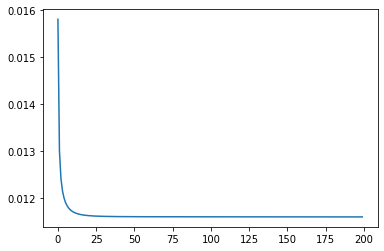

In [11]:
plt.plot(GLLR.error)
print(accuracy_score(y, GLLR.predict(X)))
print(GLLR.exec_time)

0.0007967265446980794
0.00047824780146280926
0.00049406369527181


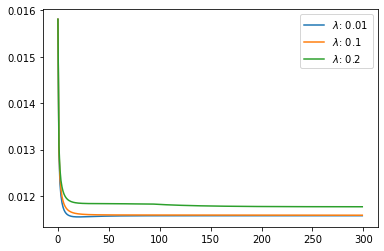

In [29]:
for lam in [0.01, 0.1, .2]:
  GLLR = GroupLassoLogisticRegression(5, lam=lam)
  GLLR.fit(X, y, max_iter=300)
  print(GLLR.exec_time)
  plt.plot(GLLR.error, label=rf'$\lambda$: {lam}')
plt.legend()
# plt.savefig('lam')

0.0005238676071166993
0.0005823588371276856
0.0004917359352111816
0.0005190237363179524


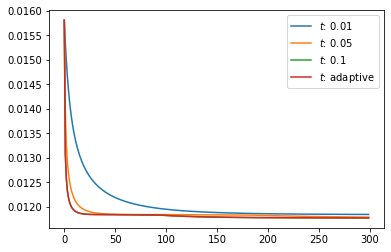

In [28]:
for step in [0.01, 0.05, 0.1, 'adaptive']:
  GLLR = GroupLassoLogisticRegression(5, step_size=step, lam=0.2)
  GLLR.fit(X, y, max_iter=300)
  print(GLLR.exec_time)
  plt.plot(GLLR.error, label=rf'$t$: {step}')
plt.legend()
# plt.savefig('step')

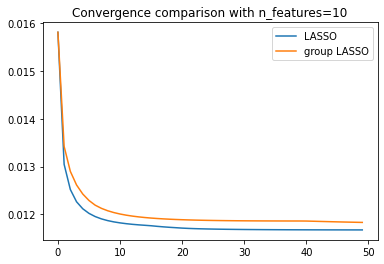

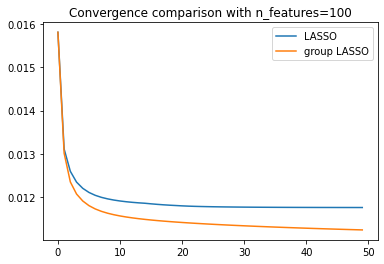

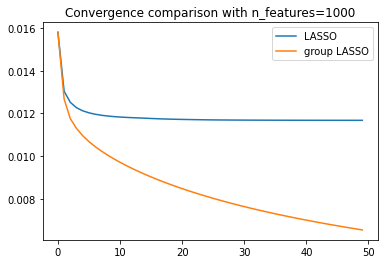

In [ ]:
for n_feat in [10, 100, 1000]:
    X, y = datasets.make_classification(n_samples=1000, n_features=n_feat, n_classes=2, n_clusters_per_class=5, random_state=12, n_informative=5, n_redundant=5, class_sep=3)
    plt.figure()
    LLR = LassoLogisticRegression(step_size=0.1)
    LLR.fit(X, y, max_iter=50)
    plt.plot(LLR.error, label='LASSO')
    GLLR = GroupLassoLogisticRegression(8, step_size=0.1)
    GLLR.fit(X, y, max_iter=50)
    plt.plot(GLLR.error, label='group LASSO')
    plt.title(f"Convergence comparison with n_features={n_feat}")
    plt.legend()
    plt.savefig(f'nfeat_{n_feat}')

In [31]:
!apt update
!apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

import re, pathlib, shutil

# Get a list of all your Notebooks
notebooks = [x for x in pathlib.Path("/content").iterdir() if 
             re.search(r"\.ipynb", x.name, flags = re.I)]

for i, n in enumerate(notebooks):
    print(f"\nProcessing  [{i+1:{len(str(len(notebooks)))}d}/{len(notebooks)}]  {n.name}\n")

    # Optionally copy your notebooks from gdrive to your vm
    # shutil.copy(n, n.name)
    n = pathlib.Path(n.name)

    !jupyter nbconvert "{n.as_posix()}" --to pdf --output "{n.stem.replace(" ", "_")}"

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-dr

In [ ]:
!pwd

/content
